In [1]:
import numpy as np
from collections import OrderedDict as odict
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
arch = {'knl':(cm.Greens, 450,0.5,0.33),'skl':(cm.Greys,200,0.5,0.75),   'p100':(cm.Blues,  550,0.5,0.43),
       'v100':(cm.Purples,850,0.5,0.85), 'i5':(cm.Wistia,30,0.5,0.79),'gtx1060':(cm.Oranges,155,0.5,0.70)}
intens={1:0.8, 2:0.6, 4:0.4}
marker={2:'d', 3:'o', 4:'s',5:'p'}
#(hardware name, number of nodes)
filesD = {
         'knl_mpi1':('knl',1), 'knl_mpi2':('knl',2), 'knl_mpi4':('knl',4),
         'skl_mpi1':('skl',1), 'skl_mpi2':('skl',2), 'skl_mpi4':('skl',4),
         'i5':('i5',1),
         'p100_mpi1':('p100',1), 'p100_mpi2':('p100',2), 'p100_mpi4':('p100',4),
         'v100_mpi1':('v100',1), 'v100_mpi2':('v100',2), 'v100_mpi4':('v100',4),
         'gtx1060':('gtx1060',1)
        }

files = odict(sorted(filesD.items(), key= lambda t : t[1][1]))
number=0
for k,v in files.items(): 
    if v[1]==1: number+=1
pd.set_option('precision',2)

In [3]:
#(axpby,dot,dxdy)
latencies = odict()
latencies['scal'] = (1,0,0)
latencies['axpby'] = (1,0,0)
latencies['pointwiseDot'] = (1,0,0)
latencies['dot'] = (0,1,0)
latencies['dx'] = (0,0,1)
latencies['dy'] = (0,0,1)
latencies['arakawa'] = (3,0,6)
latencies['cg'] = (6,2,6)
memops = odict()
memops['scal']= (2,0,0)
memops['axpby']= (3,0,0)
memops['pointwiseDot']= (6,0,0)
memops['dot']= (0,2,0)
memops['dx']= (0,0,3)
memops['dy']= (0,0,3)
memops['arakawa'] = (16,0,18) # two aliases in pointwiseDot
memops['cg'] = (20,4,18)

Now we multiply gpu latency by 0.1 for reasons yet to be discovered

In [17]:
theo = pd.read_csv('performance.csv',delimiter=' ')
theo.set_index('arch',inplace=True)
theo.index.name = None

theo.loc['p100','dxdy_lat_dist'] = 0.12*theo.loc['p100','dxdy_lat_dist']
theo.loc['v100','dxdy_lat_dist'] = 0.12*theo.loc['v100','dxdy_lat_dist']
#theo.loc['knl','axpby_bw'] = 0.9*theo.loc['knl','axpby_bw']
#theo.loc['i5','dxdy_lat_shared'] = 0.5*theo.loc['i5','dxdy_lat_shared']

theo

,axpby_bw,dot_bw,dxdy2_bw,dxdy3_bw,dxdy4_bw,dxdy5_bw,axpby_lat_shared,axpby_lat_dist,dot_lat_shared,dot_lat_dist,dxdy_lat_shared,dxdy_lat_dist
i5,29.99,0.31,0.93,0.97,0.86,0.69,0.00,NaN,82.46,NaN,0.00,NaN
skl,206.80,0.94,0.74,0.73,0.56,0.47,0.00,4.28,19.41,39.52,33.52,43.61
knl,442.58,0.32,0.56,0.38,0.27,0.22,9.38,17.95,66.01,131.36,19.18,140.96
gtx1060,157.05,0.17,0.83,0.70,0.51,0.39,0.00,NaN,124.95,NaN,1.72,NaN
p100,552.83,0.63,0.52,0.43,0.36,0.29,0.25,2.39,54.49,67.50,4.54,81.76
v100,848.30,0.70,0.95,0.85,0.77,0.62,1.23,2.89,40.29,58.92,3.26,82.89


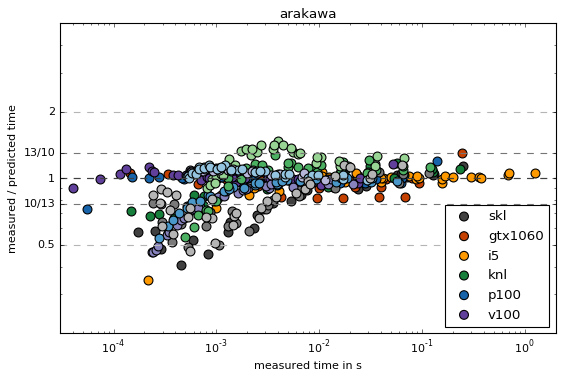

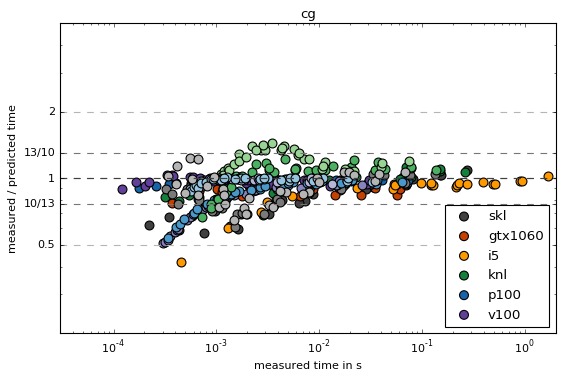

In [18]:
#now compute and plot the prediction 
for n in ['arakawa','cg'] :#latencies.keys():
    fig,ax=plt.subplots(1,1,figsize=(8,5),dpi= 80, facecolor='w', edgecolor='k')
    xs = np.array([3e-5,2.0])
    ys = np.array([1.0,1.0])
    for frac in [1.0,13/10,8/4]:
        plt.plot(xs,frac*ys,ls='--',color=cm.Greys(0.8/frac))
        plt.plot(xs,1/frac*ys,ls='--',color=cm.Greys(0.8/frac))
        
    for f, v in files.items() :#{'knl_mpi2':('knl',2)}.items():

        df=pd.read_csv('benchmark_'+f+'.csv', delimiter=' ')
        #add size and get rid of non-relevant columns
        df.insert(0,'size', 8*df['n']*df['n']*df['Nx']*df['Ny']/1e6/v[1])
        dfr = df[['n','Nx','Ny','size']+list(memops.keys())]
        #compute mean and standard derivation of 'same' groups 
        dfr=dfr.groupby(['n', 'Nx','Ny','size']).mean()
        dfr=dfr.reset_index(level=['n','Nx','Ny','size'])

        dfr['FirstLevel']='measured'
        dfr.columns=pd.MultiIndex.from_product([dfr.columns,['measured']])
        del dfr['FirstLevel']
        
        dfr['dxdy_bw'] = dfr.apply( 
            lambda row: theo.loc[v[0],'dxdy'+str(row['n','measured'].astype(int))+'_bw'], axis=1)

        dxdystring = 'dxdy_lat_shared'
        dotstring = 'dot_lat_shared'
        if v[1] > 1 : 
            dxdystring = 'dxdy_lat_dist'
            dotstrint = 'dot_lat_dist'
        for q,l in latencies.items():
            m = memops[q]
            dfr.loc[:,(q,'predicted')] = (
                                    ( l[0]*theo.loc[v[0],'axpby_lat_shared']+
                                      l[1]*theo.loc[v[0],dotstring] +
                                      l[2]*theo.loc[v[0],dxdystring]
                                    )*1e-6+
                                    (m[0] + m[1]/theo.loc[v[0],'dot_bw'] + m[2]/dfr['dxdy_bw',''])
                                       *dfr[('size','measured')]/1000/theo.loc[v[0],'axpby_bw'])
            dfr.loc[:,(q,'meas/pred')]=dfr[(q,'measured')]/dfr[(q,'predicted')]
        dfr.sort_values(by=('size','measured'),inplace=True)
        dfr[n].plot(kind='scatter',ax=ax,color=arch[v[0]][0](intens[v[1]]),edgecolors='k',
                      x='measured',y='meas/pred',label=v[0],s=64)
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = handles[0:number]; labels = labels[0:number]

    #plt.plot(xs,ys)

    
    plt.legend(handles, labels, loc='lower right',scatterpoints=1)
    plt.xscale('log')
    plt.xlim(xs[0],xs[1])
    plt.xlabel('measured time in s')
    plt.ylabel('measured / predicted time')
    plt.yscale('log')
    plt.ylim(0.2,5)
    plt.yticks([0.5,10/13,1,1.3,2],[0.5,'10/13',1,'13/10',2])
    plt.title(n)
    plt.savefig(n+'.pdf')

### Conclusions
- black lines indicate factors 1, 1.3 and 2 respectively
- why are GPU latencies in MPI implementation hidden?

In [6]:
theo.to_latex()

'\\begin{tabular}{lrrrrrrrrrrrr}\n\\toprule\n{} &  axpby\\_bw &  dot\\_bw &  dxdy2\\_bw &  dxdy3\\_bw &  dxdy4\\_bw &  dxdy5\\_bw &  axpby\\_lat\\_shared &  axpby\\_lat\\_dist &  dot\\_lat\\_shared &  dot\\_lat\\_dist &  dxdy\\_lat\\_shared &  dxdy\\_lat\\_dist \\\\\n\\midrule\ni5      &     29.99 &    0.31 &      0.93 &      0.97 &      0.86 &      0.69 &             12.38 &             NaN &          117.43 &           NaN &            28.67 &            NaN \\\\\nskl     &    206.80 &    0.94 &      0.74 &      0.73 &      0.56 &      0.47 &              6.10 &            6.03 &           24.48 &         40.68 &            41.12 &          45.35 \\\\\nknl     &    442.58 &    0.32 &      0.57 &      0.39 &      0.28 &      0.22 &             13.40 &           19.00 &           68.68 &        132.05 &            23.19 &         142.00 \\\\\ngtx1060 &    157.05 &    0.17 &      0.83 &      0.70 &      0.51 &      0.39 &              3.51 &             NaN &          131.63 &          